# EVP-KLEE Performance Analysis Figures

This notebook generates publication-quality figures for the EVP-KLEE paper.

## Figures Generated:
1. **RQ1**: Parallel Coordinates Plot
2. **RQ1**: Improvement Heatmap
3. **RQ2**: Overhead vs Benefit Analysis
4. **RQ3**: Performance Variation Analysis


In [1]:
# Import required libraries
import sys
from pathlib import Path
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import warnings
warnings.filterwarnings('ignore')

# Add scripts directory to path
script_dir = Path('/home/roxana/VASE-klee/EVP-KLEE/scripts')
sys.path.insert(0, str(script_dir))

# Import data processing functions
from EVP_data_processor import (
    load_and_process_data,
    prepare_rq1_analysis,
    prepare_rq2_analysis,
    prepare_rq3_analysis
)


In [2]:
# Load and process data
print("Loading data from CSV files...")
df = load_and_process_data()

print(f"\nLoaded data for {df['Program'].nunique()} programs")
print(f"Total data points: {len(df)}")

# Prepare analysis dataframes
rq1_df = prepare_rq1_analysis(df)
rq2_df = prepare_rq2_analysis(df)
rq3_df = prepare_rq3_analysis(df)

print("\nData preparation complete!")
print(f"\nRQ1 data shape: {rq1_df.shape}")
print(f"RQ2 data shape: {rq2_df.shape}")
print(f"RQ3 data shape: {rq3_df.shape}")


Loading data from CSV files...
Processing /home/roxana/VASE-klee/EVP-KLEE/results/temp_results/coreutils-tmp/cp/cp-stats-evp.csv...
Processing /home/roxana/VASE-klee/EVP-KLEE/results/temp_results/coreutils-tmp/cp/cp-stats-vanilla.csv...
Processing /home/roxana/VASE-klee/EVP-KLEE/results/temp_results/coreutils-tmp/chmod/chmod-stats-evp.csv...
Processing /home/roxana/VASE-klee/EVP-KLEE/results/temp_results/coreutils-tmp/chmod/chmod-stats-vanilla.csv...
Processing /home/roxana/VASE-klee/EVP-KLEE/results/temp_results/coreutils-tmp/mv/mv-stats-evp.csv...
Processing /home/roxana/VASE-klee/EVP-KLEE/results/temp_results/coreutils-tmp/mv/mv-stats-vanilla.csv...
Processing /home/roxana/VASE-klee/EVP-KLEE/results/temp_results/coreutils-tmp/du/du-stats-evp.csv...
Processing /home/roxana/VASE-klee/EVP-KLEE/results/temp_results/coreutils-tmp/du/du-stats-vanilla.csv...
Processing /home/roxana/VASE-klee/EVP-KLEE/results/temp_results/coreutils-tmp/ln/ln-stats-evp.csv...
Processing /home/roxana/VASE-kle

## Figure 1: RQ1 - Parallel Coordinates Plot


Figure 1 saved: rq1-parallel-coordinates-new.pdf and .png


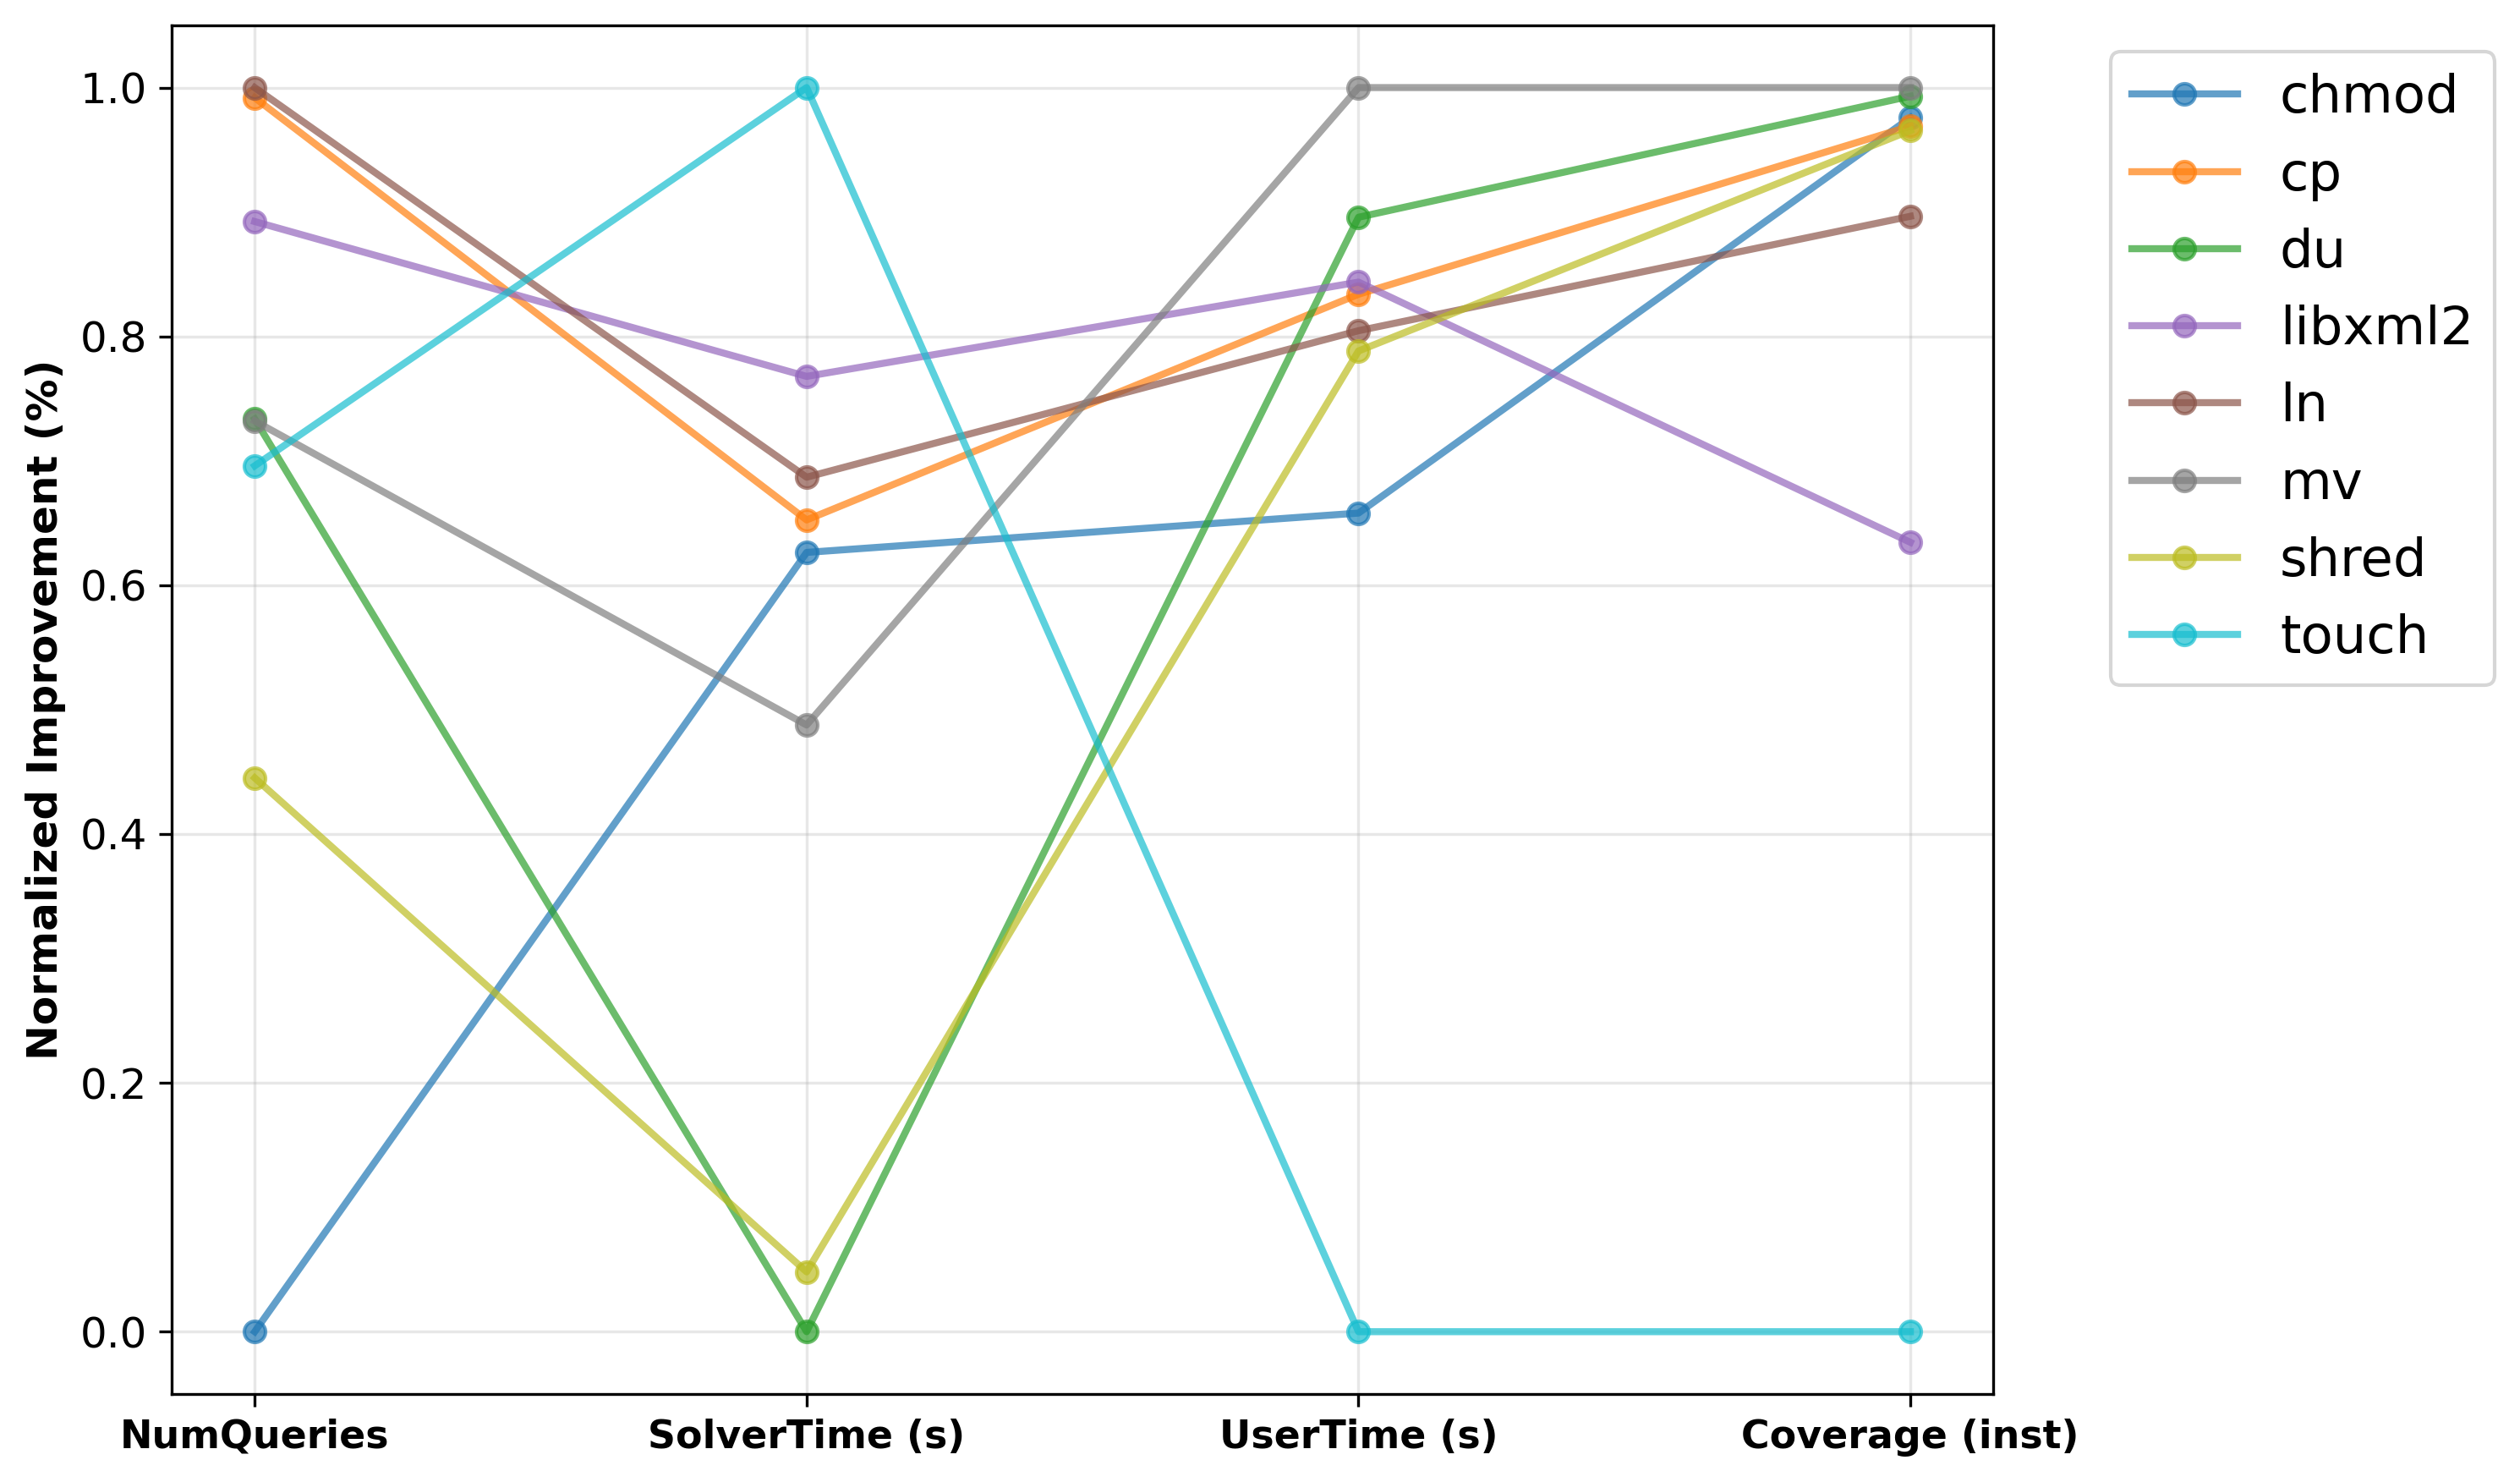

In [27]:
# Set up matplotlib parameters for publication quality
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

# Prepare data for parallel coordinates
programs = sorted(df['Program'].unique())
# metrics = ['QueryTime (s)', 'SolverTime (s)', 'UserTime (s)', 'Coverage (inst)']  # QueryTime COMMENTED OUT
metrics = ['NumQueries', 'SolverTime (s)', 'UserTime (s)', 'Coverage (inst)']

# Create parallel coordinates data
parallel_data = []
for program in programs:
    program_data = rq1_df[rq1_df['Program'] == program]
    if len(program_data) >= 4:  # Need all 4 metrics
        row = {'Program': program}
        for metric in metrics:
            metric_data = program_data[program_data['Metric'] == metric]
            if not metric_data.empty:
                row[metric] = metric_data.iloc[0]['Improvement (%)']
            else:
                row[metric] = 0
        parallel_data.append(row)

parallel_df = pd.DataFrame(parallel_data)

if not parallel_df.empty:
    # Create parallel coordinates plot
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Normalize data for parallel coordinates
    normalized_data = parallel_df[metrics].copy()
    for col in metrics:
        col_min = normalized_data[col].min()
        col_max = normalized_data[col].max()
        if col_max > col_min:
            normalized_data[col] = (normalized_data[col] - col_min) / (col_max - col_min)
        else:
            normalized_data[col] = 0.5
    
    # Plot lines for each program
    colors = plt.cm.tab10(np.linspace(0, 1, len(parallel_df)))
    for idx, (_, row) in enumerate(parallel_df.iterrows()):
        values = [normalized_data.loc[idx, metric] for metric in metrics]
        ax.plot(range(len(metrics)), values, marker='o', linewidth=2, 
                label=row['Program'], color=colors[idx], alpha=0.7)
    
    ax.set_xticks(range(len(metrics)))
    ax.set_xticklabels(metrics, fontsize=11, fontweight='bold')
    ax.set_ylabel('Normalized Improvement (%)', fontsize=12, fontweight='bold')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1, fontsize=15)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Leave space for legend on right
    plt.savefig('rq1-parallel-coordinates-new.pdf', dpi=300, bbox_inches='tight')
    plt.savefig('rq1-parallel-coordinates-new.png', dpi=300, bbox_inches='tight')
    print("Figure 1 saved: rq1-parallel-coordinates-new.pdf and .png")
    plt.show()
else:
    print("Warning: No data available for parallel coordinates plot")


## Figure 2: RQ1 - Improvement Heatmap


Figure 2 saved: rq1-improvement-heatmap-new.pdf and .png


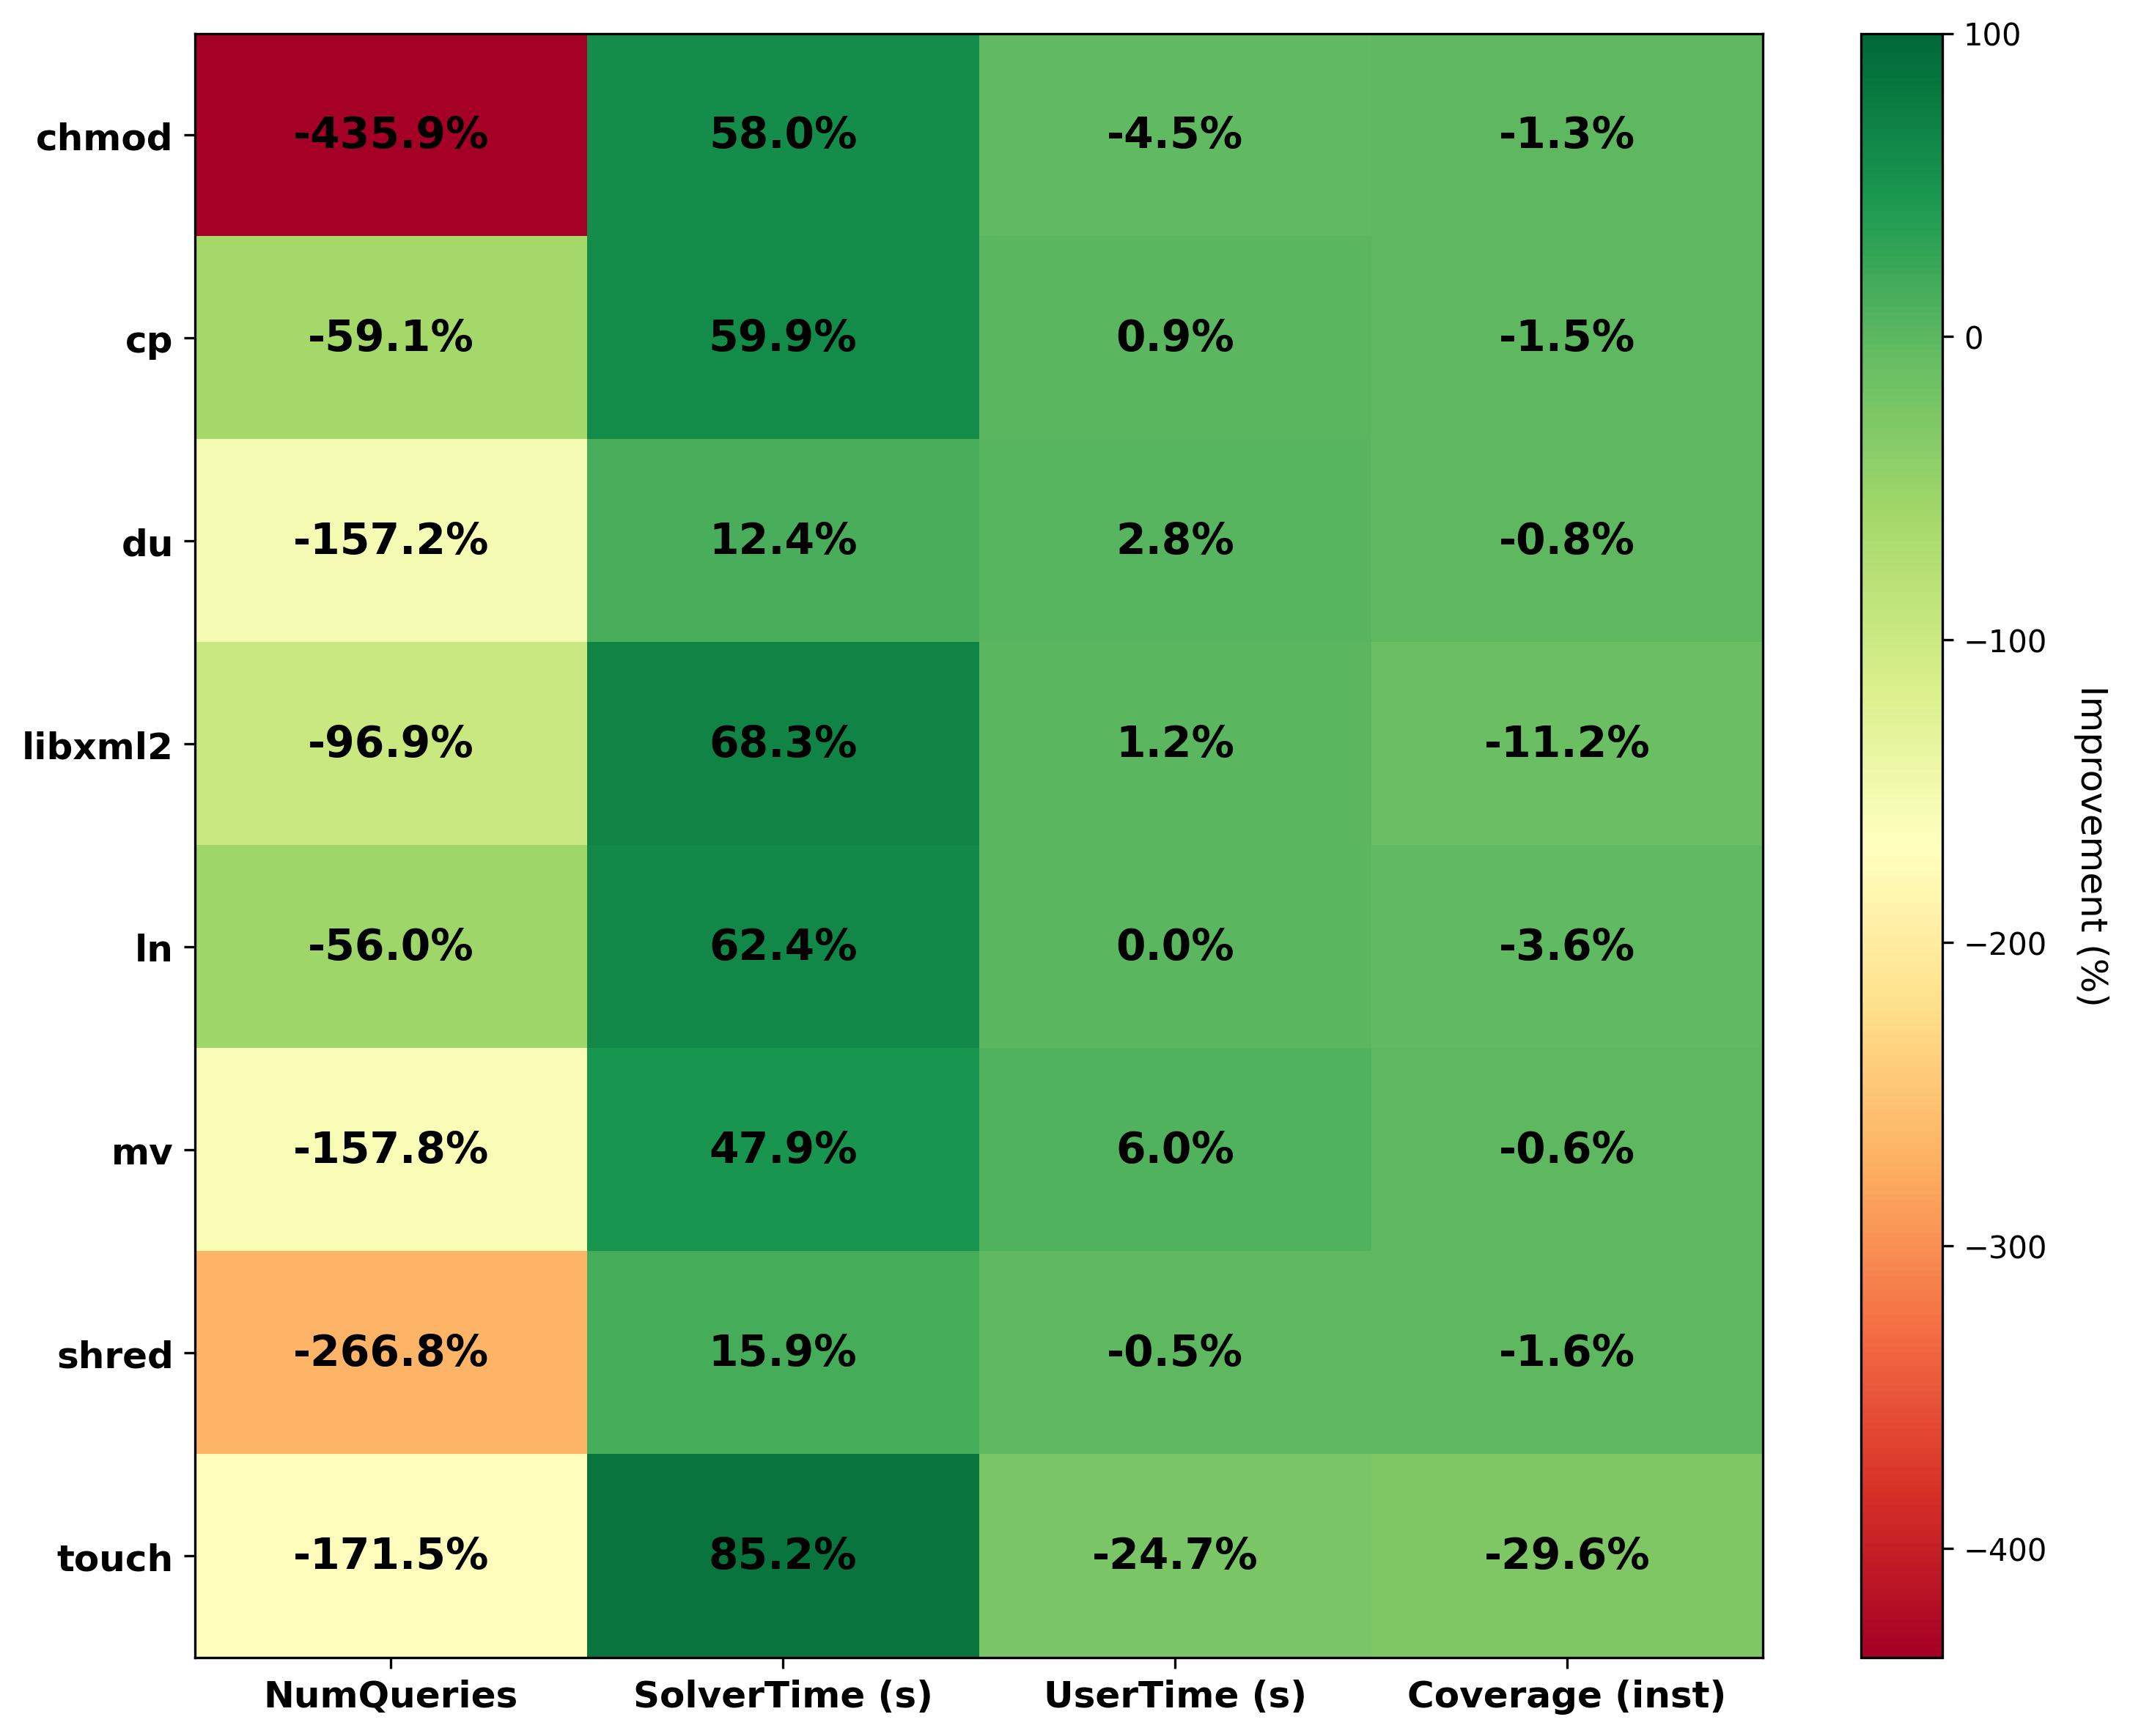

In [25]:
# Create heatmap data
heatmap_data = []
for program in programs:
    program_data = rq1_df[rq1_df['Program'] == program]
    row = {'Program': program}
    for metric in metrics:
        metric_data = program_data[program_data['Metric'] == metric]
        if not metric_data.empty:
            row[metric] = metric_data.iloc[0]['Improvement (%)']
        else:
            row[metric] = 0
    heatmap_data.append(row)

heatmap_df = pd.DataFrame(heatmap_data).set_index('Program')

if not heatmap_df.empty:
    # Create heatmap
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Determine vmin and vmax for better visualization
    all_values = heatmap_df.values.flatten()
    vmin = min(all_values.min(), -50)
    vmax = max(all_values.max(), 100)
    
    im = ax.imshow(heatmap_df.values, cmap='RdYlGn', aspect='auto', vmin=vmin, vmax=vmax)
    
    # Set axis labels
    #ax.set_title('RQ1: Improvement Heatmap', fontsize=14, fontweight='bold')
    
    # Set ticks and labels
    ax.set_xticks(np.arange(len(metrics)))
    ax.set_yticks(np.arange(len(programs)))
    ax.set_xticklabels(metrics, fontsize=12, fontweight='bold')
    ax.set_yticklabels(heatmap_df.index, fontsize=12, fontweight='bold')
    
    # Add text annotations
    for i in range(len(programs)):
        for j in range(len(metrics)):
            text = ax.text(j, i, f"{heatmap_df.iloc[i, j]:.1f}%",
                          ha="center", va="center", color="black", fontsize=14, fontweight="bold")
    
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Improvement (%)', rotation=270, labelpad=20)
    
    plt.tight_layout()
    plt.savefig('rq1-improvement-heatmap-new.pdf', dpi=300, bbox_inches='tight')
    plt.savefig('rq1-improvement-heatmap-new.png', dpi=300, bbox_inches='tight')
    print("Figure 2 saved: rq1-improvement-heatmap-new.pdf and .png")
    plt.show()
else:
    print("Warning: No data available for heatmap")


## Figure 3: RQ2 - Overhead vs Benefit Analysis


Figure 3 saved: rq2-overhead-benefit-new.pdf and .png


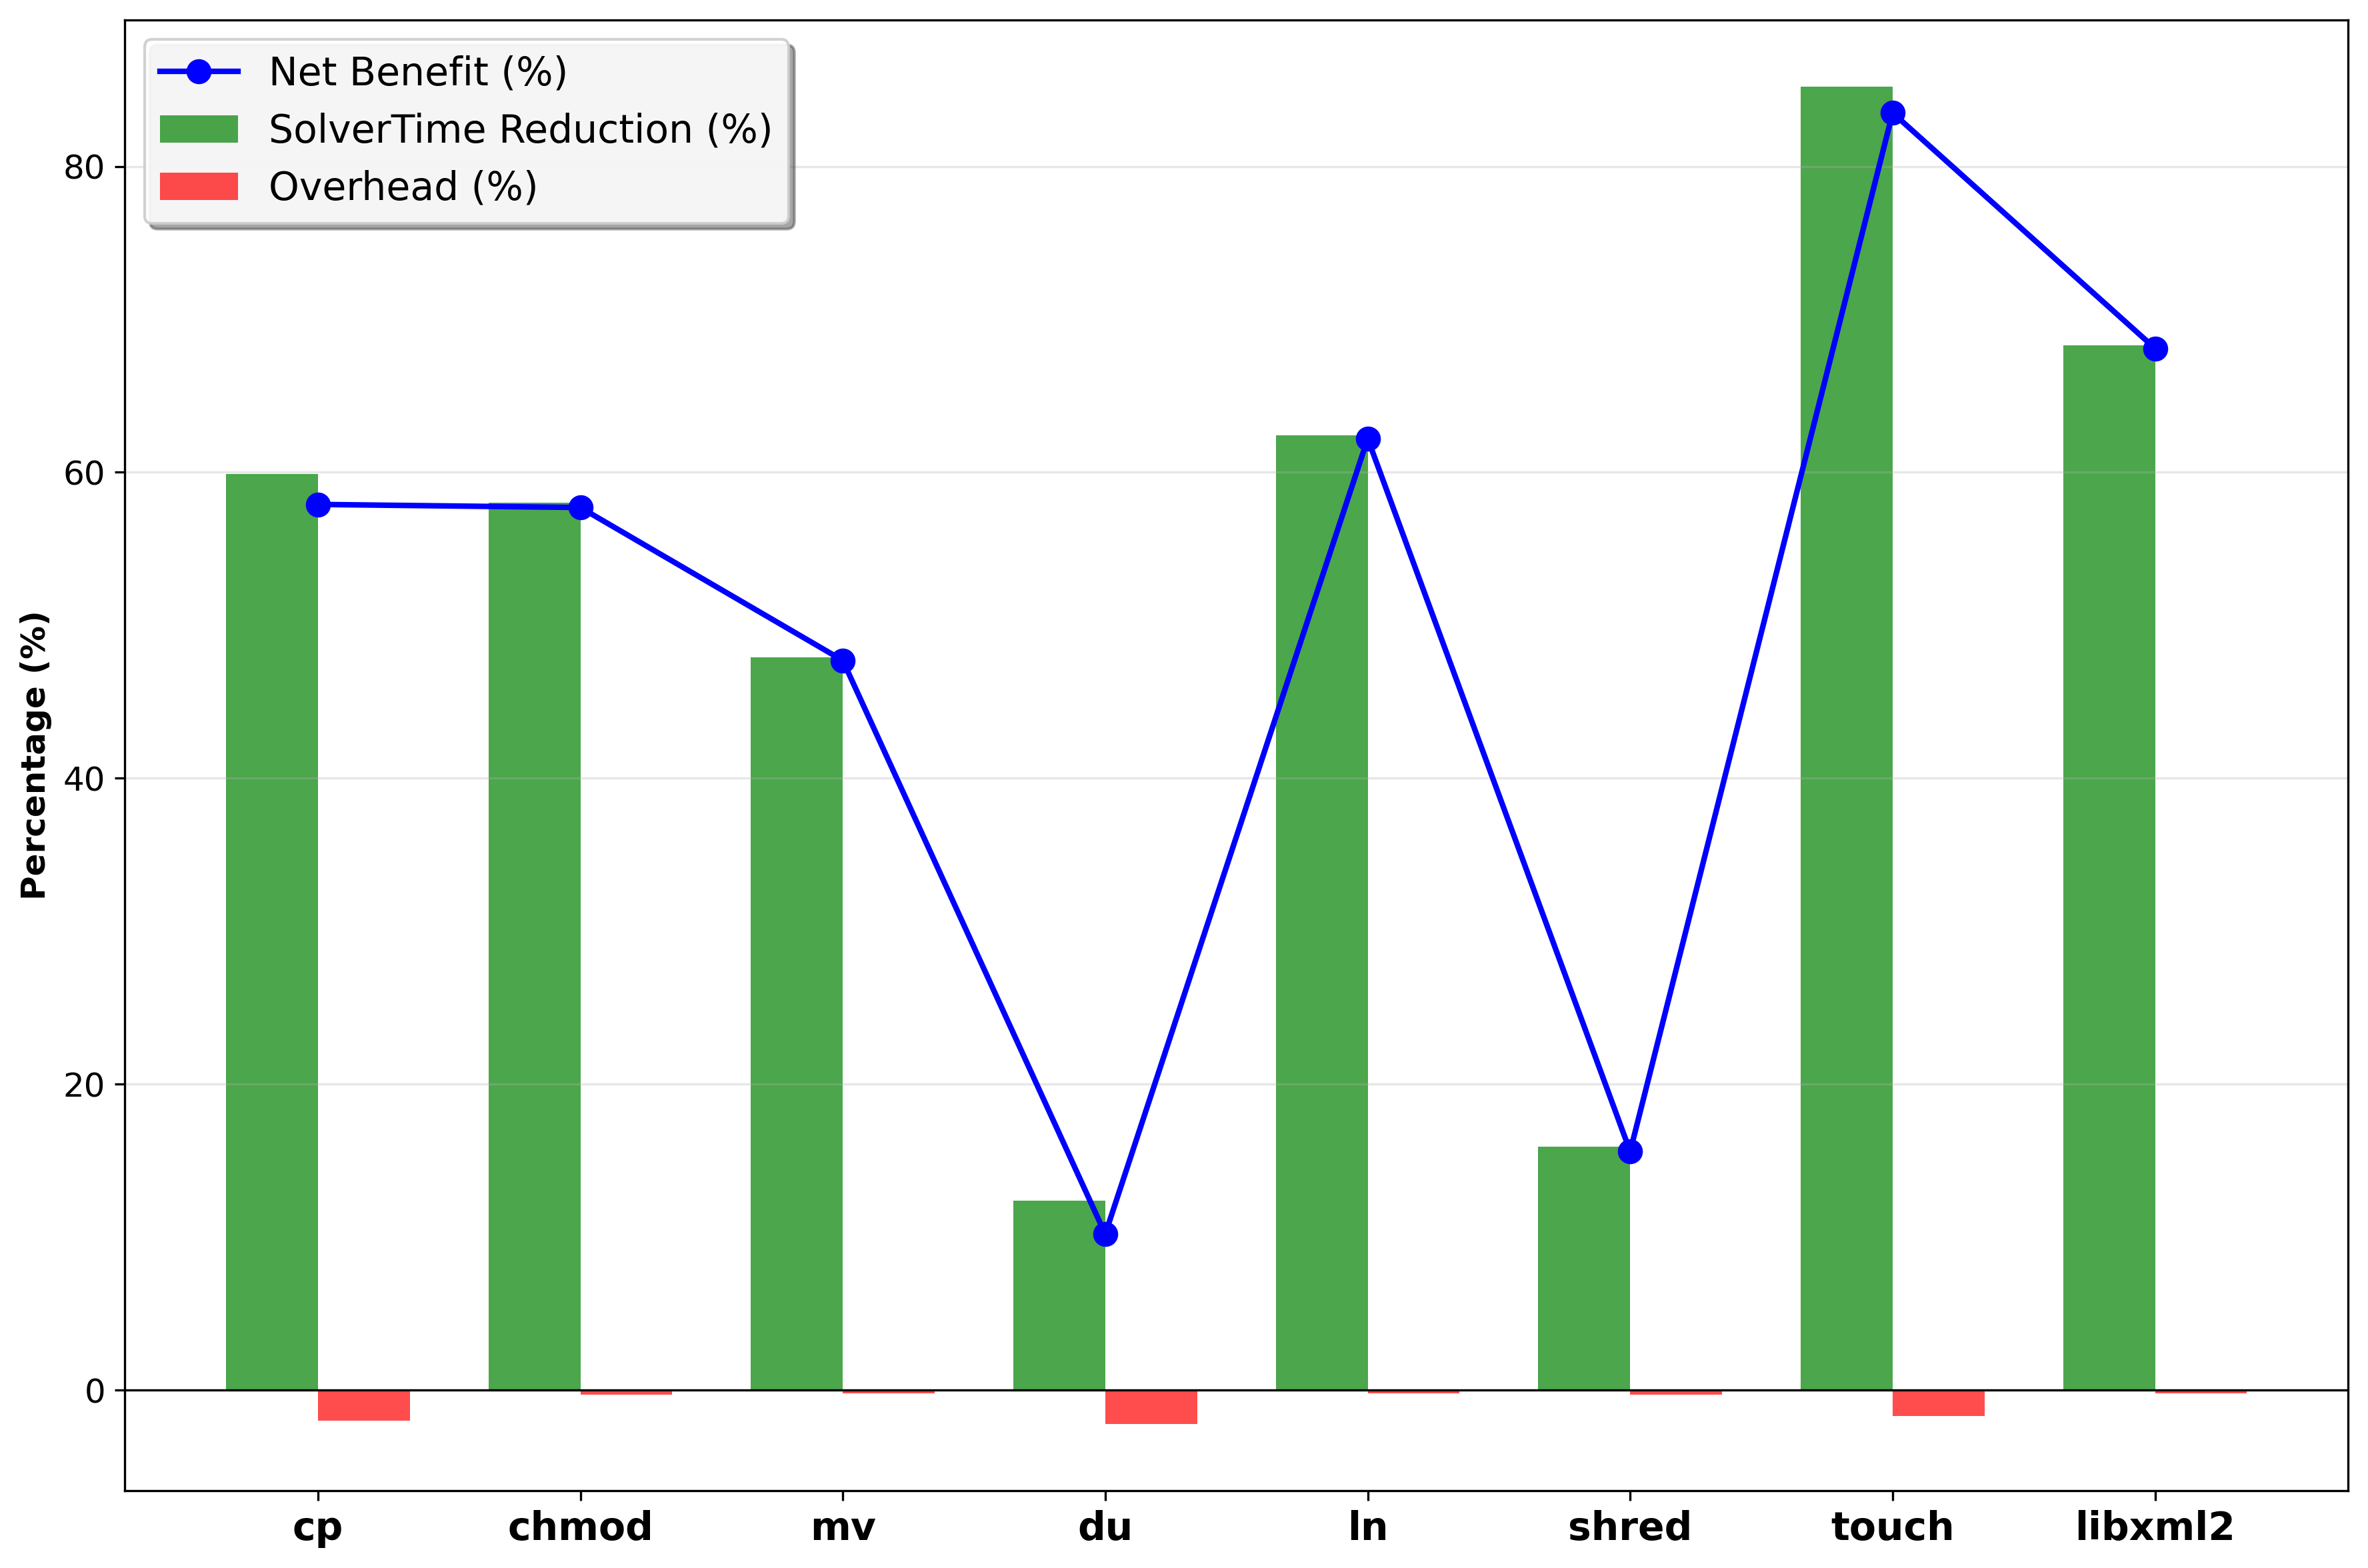

In [29]:
# Prepare RQ2 data - Get solver time improvements from RQ1
solver_improvements = {}
for program in programs:
    program_data = rq1_df[(rq1_df['Program'] == program) & 
                          (rq1_df['Metric'] == 'SolverTime (s)')]
    if not program_data.empty:
        solver_improvements[program] = program_data.iloc[0]['Improvement (%)']
    else:
        solver_improvements[program] = 0

# Merge with RQ2 overhead data
overhead_benefit_data = []
for _, row in rq2_df.iterrows():
    program = row['Program']
    overhead = row['Overhead (%)']
    benefit = solver_improvements.get(program, 0)
    overhead_benefit_data.append({
        'Program': program,
        'Overhead (%)': overhead,
        'Benefit (%)': benefit,
        'Net Benefit (%)': benefit - overhead
    })

ob_df = pd.DataFrame(overhead_benefit_data)

if not ob_df.empty:
    # Create bar chart
    fig, ax = plt.subplots(figsize=(12, 8))
    
    x = np.arange(len(ob_df))
    width = 0.35
    
    # Create bars
    bars1 = ax.bar(x - width/2, ob_df['Benefit (%)'], width, 
                   label='SolverTime Reduction (%)', 
                   color='green', alpha=0.7)
    bars2 = ax.bar(x + width/2, -ob_df['Overhead (%)'], width, label='Overhead (%)', 
                   color='red', alpha=0.7)
    
    # Add net benefit line
    ax.plot(x, ob_df['Net Benefit (%)'], 'o-', color='blue', linewidth=2, markersize=8,
                   label='Net Benefit (%)')
    
    ax.set_ylabel('Percentage (%)', fontsize=12, fontweight='bold')
    ###ax.set_title('RQ2: Overhead vs SolverTime Reduction Analysis', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(ob_df['Program'], fontsize=14, fontweight='bold')
    ax.legend(loc='upper left', fontsize=14, frameon=True, fancybox=True, shadow=True, framealpha=0.9)
    ax.grid(True, alpha=0.3, axis='y')
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
    
    plt.tight_layout()
    plt.savefig('rq2-overhead-benefit-new.pdf', dpi=300, bbox_inches='tight')
    plt.savefig('rq2-overhead-benefit-new.png', dpi=300, bbox_inches='tight')
    print("Figure 3 saved: rq2-overhead-benefit-new.pdf and .png")
    plt.show()
else:
    print("Warning: No data available for overhead-benefit plot")


## Figure 4: RQ3 - Performance Variation Analysis


Figure 4 saved: rq3-performance-variation.pdf and .png


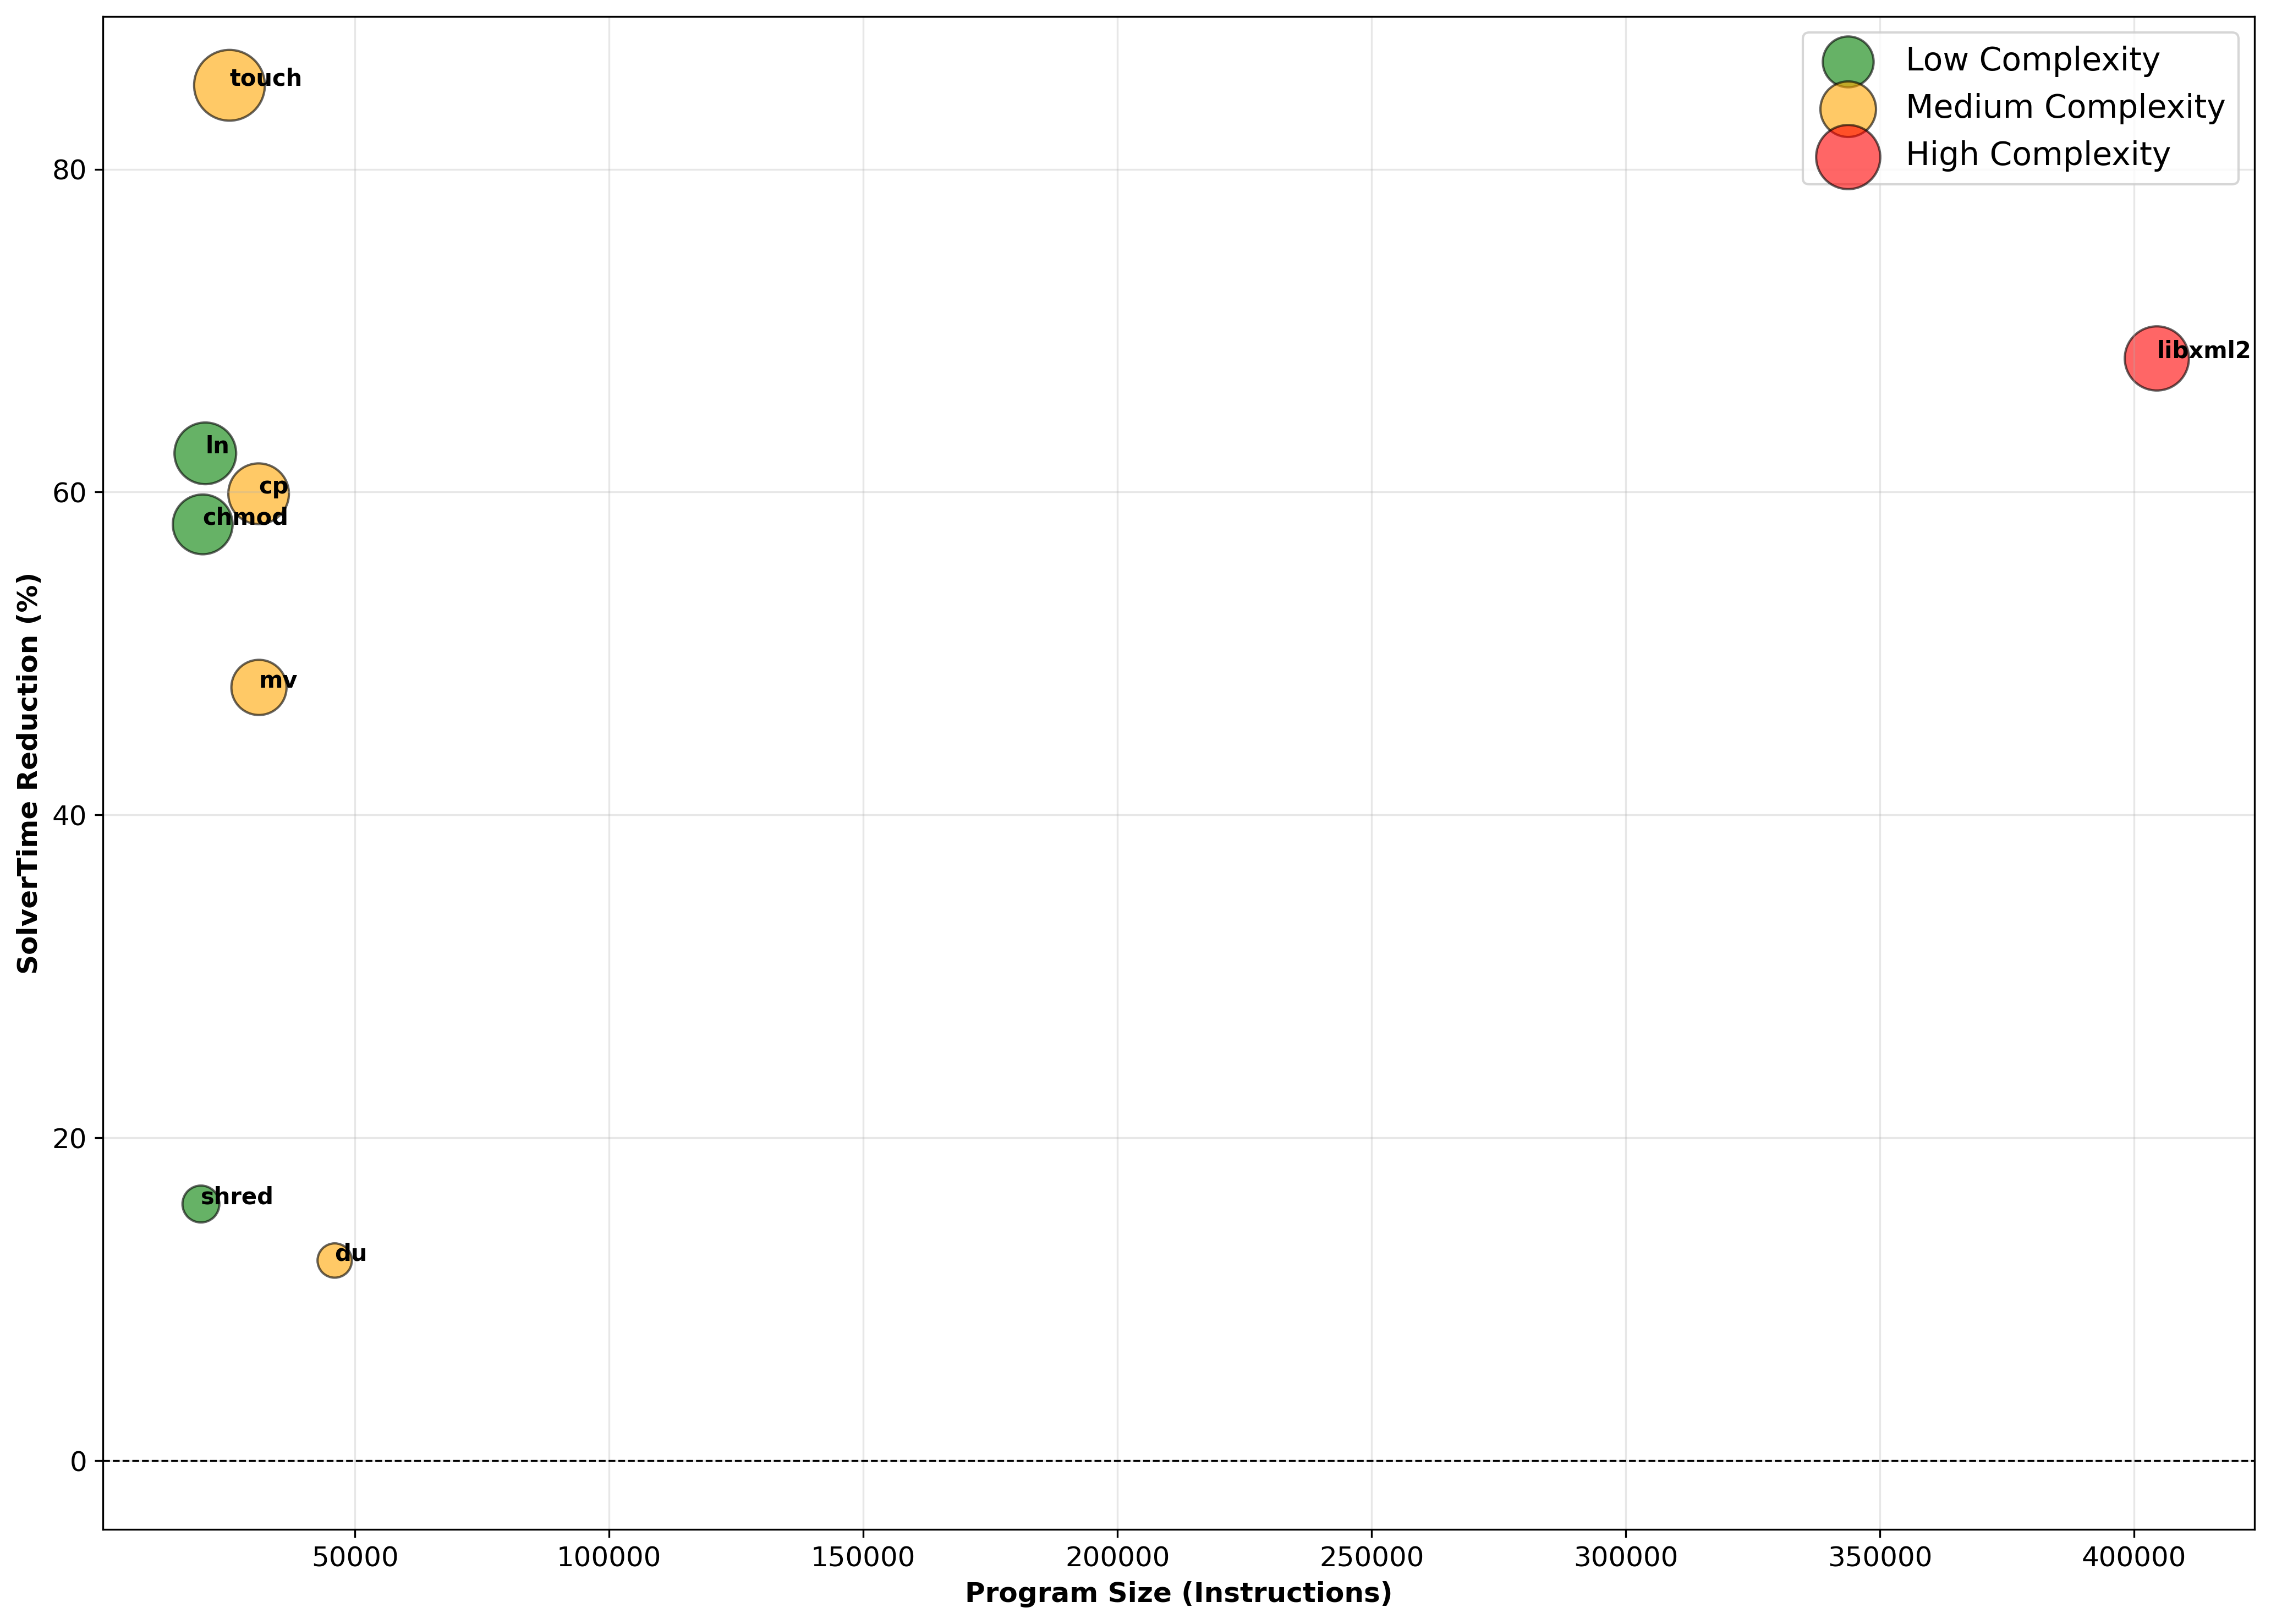

In [30]:
# Create scatter plot showing performance variation
if not rq3_df.empty:
    fig, ax = plt.subplots(figsize=(14, 10))
    # Color code by complexity
    complexity_colors = {'Low': 'green', 'Medium': 'orange', 'High': 'red'}
    for complexity in ['Low', 'Medium', 'High']:
        complexity_data = rq3_df[rq3_df['Complexity'] == complexity]
        if not complexity_data.empty:
            ax.scatter(complexity_data['Instructions'], 
                      complexity_data['SolverTime Reduction (%)'],
                      s=complexity_data['SolverTime Reduction (%)'].abs() * 10 + 100,
                      c=complexity_colors[complexity],
                      label=f'{complexity} Complexity',
                      alpha=0.6, edgecolors='black', linewidth=1)
    # Add program labels
    for _, row in rq3_df.iterrows():
        ax.annotate(row['Program'],
                   (row['Instructions'], row['SolverTime Reduction (%)']),
                   fontsize=10, fontweight='bold')
    ax.set_xlabel('Program Size (Instructions)', fontsize=12, fontweight='bold')
    ax.set_ylabel('SolverTime Reduction (%)', fontsize=12, fontweight='bold')
    ##ax.set_title('RQ3: Performance Variation Across Program Characteristics', fontsize=14, fontweight='bold')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
    plt.tight_layout()
    plt.savefig('rq3-performance-variation.pdf', dpi=300, bbox_inches='tight')
    plt.savefig('rq3-performance-variation.png', dpi=300, bbox_inches='tight')
    print("Figure 4 saved: rq3-performance-variation.pdf and .png")
    plt.show()
else:
    print("Warning: No data available for RQ3 plot")


## Alternative RQ3 Visualizations

Below are three alternative visualization options for RQ3. Run each cell to see the different plot types and choose the one that best fits your paper.


### Option 1: Sorted Bar Chart (Per-Program SolverTime Reduction)


Option 1 saved: rq3-bar-chart-sorted.pdf and .png


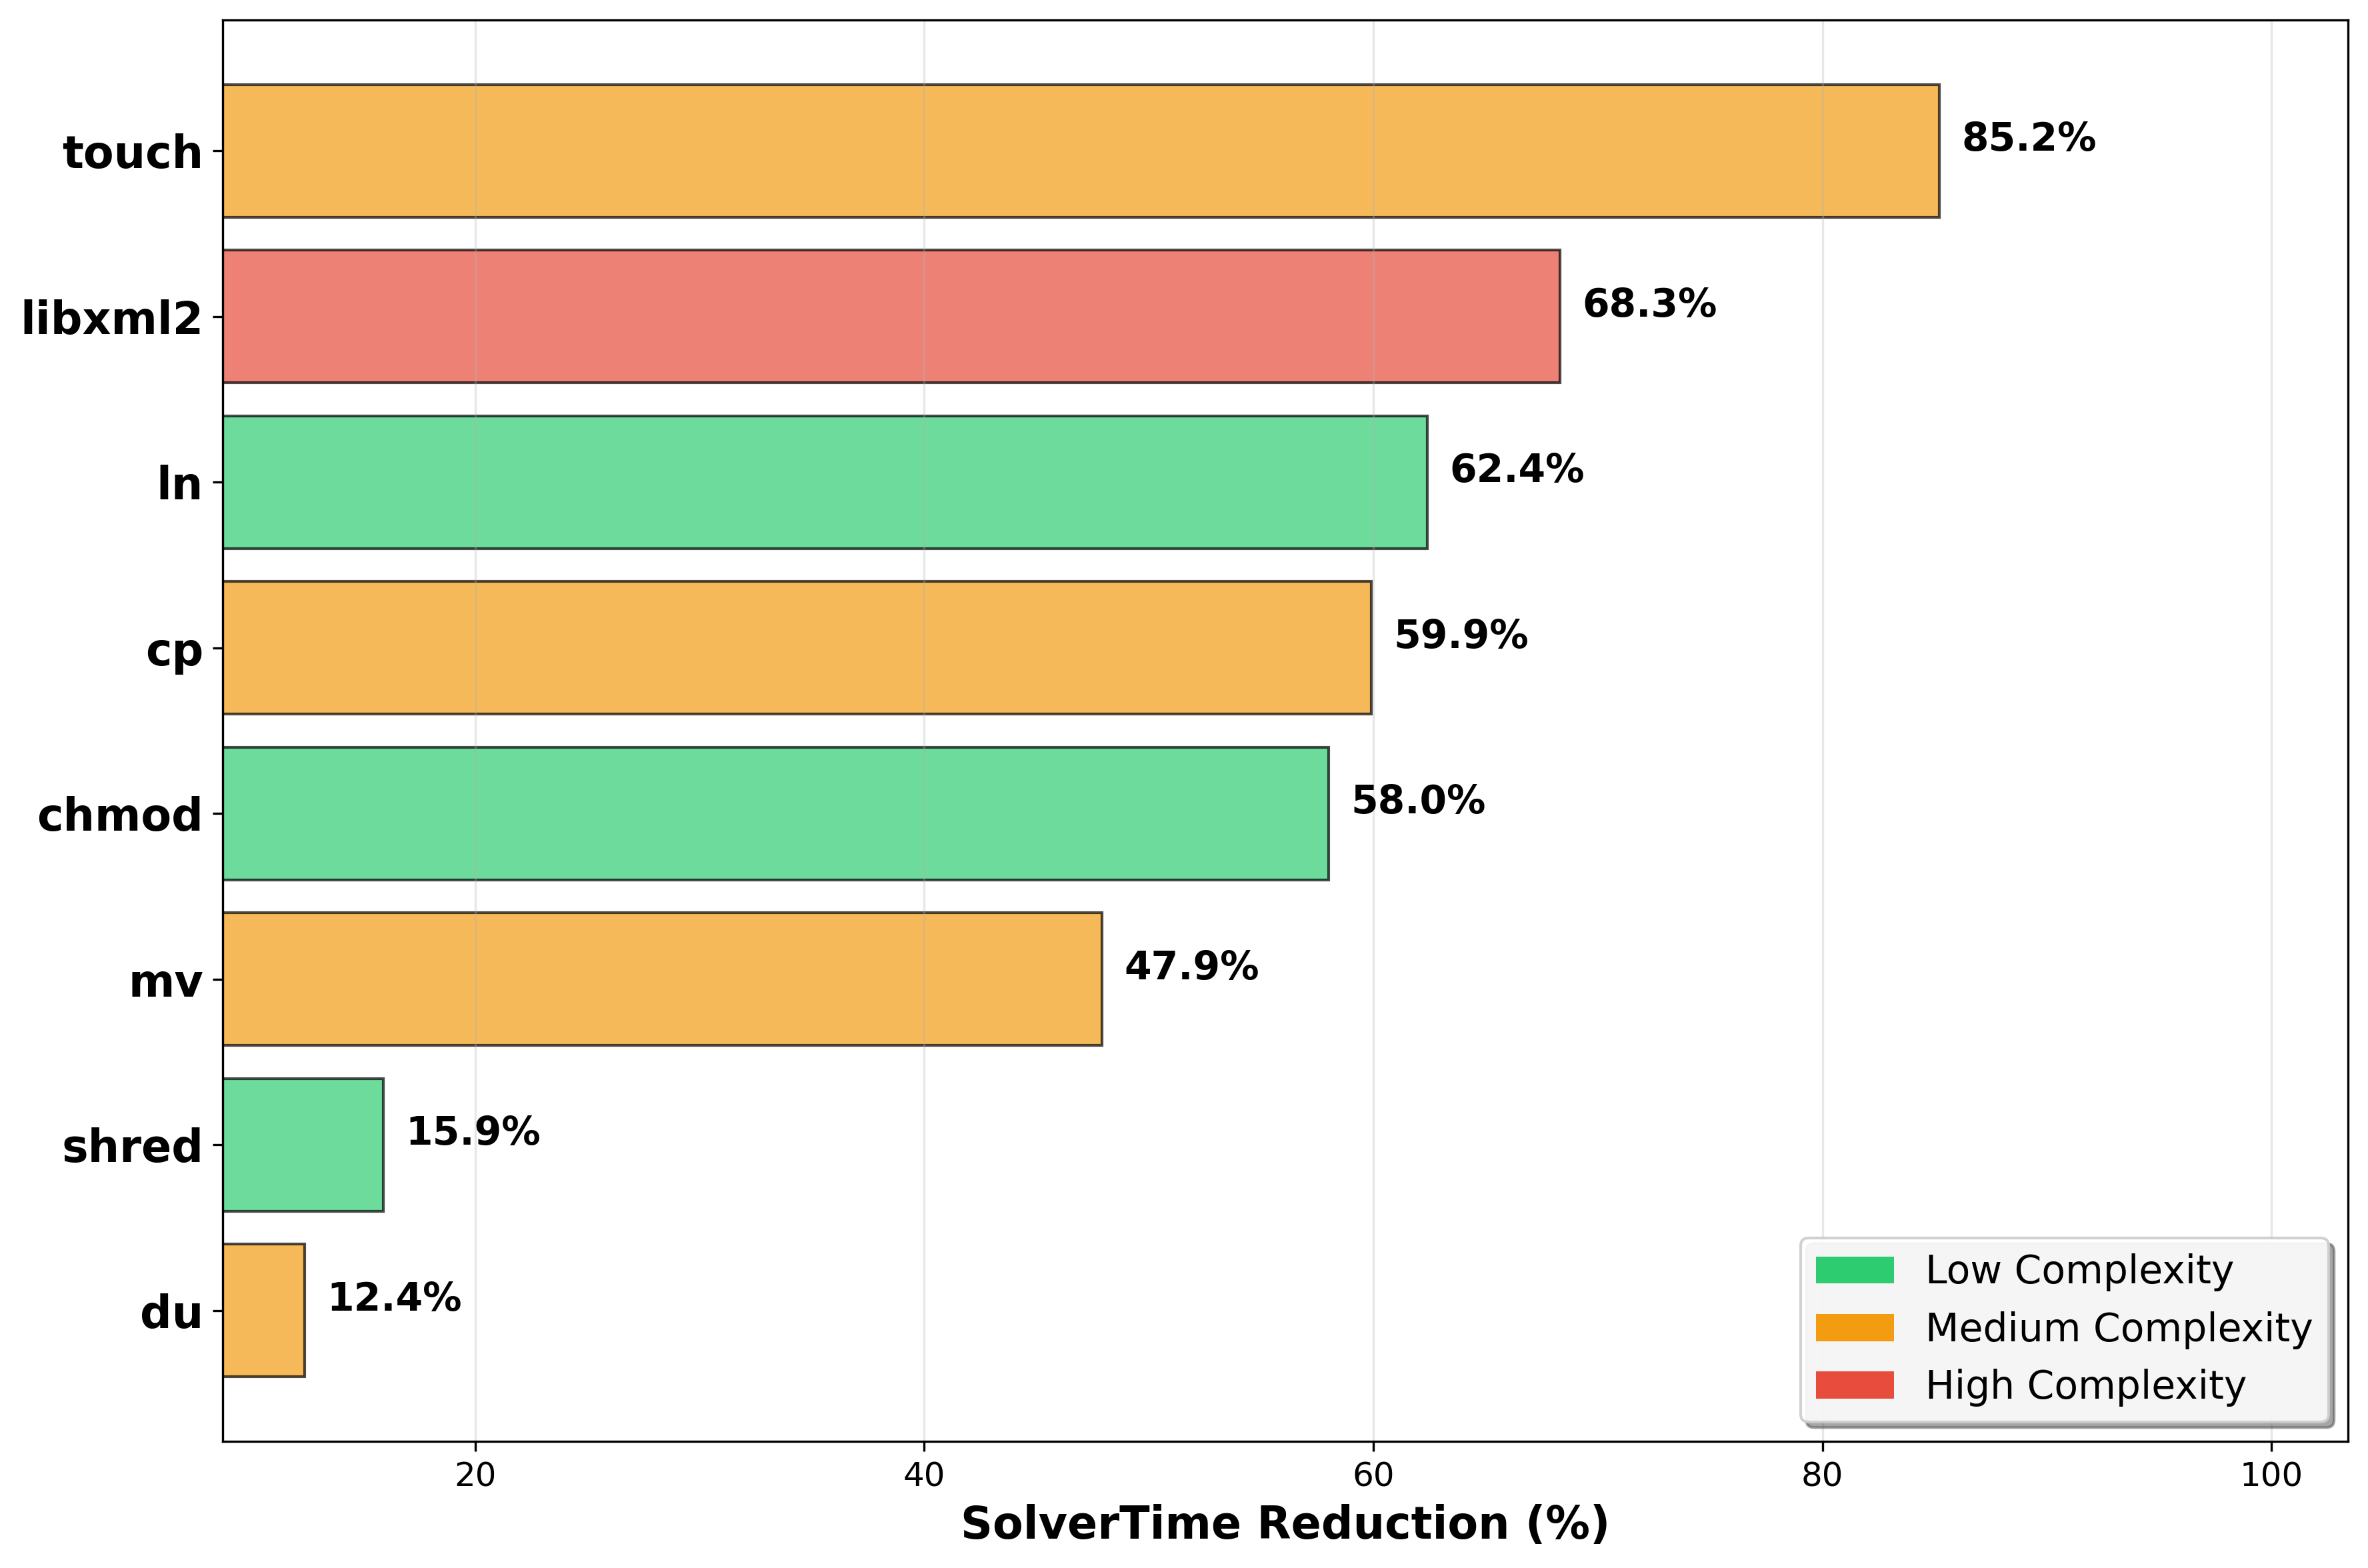

In [35]:
# Option 1: Sorted Bar Chart - Show per-program improvement
if not rq3_df.empty:
    # Sort by SolverTime Reduction for better visualization
    sorted_df = rq3_df.sort_values('SolverTime Reduction (%)', ascending=True)
    fig, ax = plt.subplots(figsize=(12, 8))
    # Create color map based on complexity
    complexity_colors = {'Low': '#2ecc71', 'Medium': '#f39c12', 'High': '#e74c3c'}
    colors = [complexity_colors[comp] for comp in sorted_df['Complexity']]
    # Create horizontal bar chart
    bars = ax.barh(range(len(sorted_df)), sorted_df['SolverTime Reduction (%)'], 
                   color=colors, alpha=0.7, edgecolor='black', linewidth=1)
    # Add value labels on bars
    for i, (idx, row) in enumerate(sorted_df.iterrows()):
        value = row['SolverTime Reduction (%)']
        ax.text(value + 1 if value >= 0 else value - 1, i,
               f'{value:.1f}%',
               fontsize=14, fontweight='bold')
    ax.set_yticks(range(len(sorted_df)))
    ax.set_yticklabels(sorted_df['Program'], fontsize=16, fontweight='bold')
    ax.set_xlabel('SolverTime Reduction (%)', fontsize=16, fontweight='bold')
    # Extend x-axis range to accommodate text labels
    x_max = sorted_df['SolverTime Reduction (%)'].max()
    x_min = sorted_df['SolverTime Reduction (%)'].min()
    x_range = x_max - x_min
    ax.set_xlim(x_min - x_range * 0.05, x_max + x_range * 0.25)  # Add 25% more space on right for labels
    ax.grid(True, alpha=0.3, axis='x')
    ax.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
    # Add legend for complexity (Patch already imported at top)
    legend_elements = [Patch(facecolor=complexity_colors['Low'], label='Low Complexity'),
                      Patch(facecolor=complexity_colors['Medium'], label='Medium Complexity'),
                      Patch(facecolor=complexity_colors['High'], label='High Complexity')]
    ax.legend(handles=legend_elements, loc='lower right', fontsize=14, frameon=True, fancybox=True, shadow=True, framealpha=0.9)
    #####ax.set_title('RQ3: SolverTime Reduction by Program (Sorted)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('rq3-bar-chart-sorted.pdf', dpi=300, bbox_inches='tight')
    plt.savefig('rq3-bar-chart-sorted.png', dpi=300, bbox_inches='tight')
    print("Option 1 saved: rq3-bar-chart-sorted.pdf and .png")
    plt.show()
else:
    print("Warning: No data available for bar chart")


### Option 2: Box Plot (Distribution by Complexity)


Option 2 saved: rq3-box-plot-complexity.pdf and .png


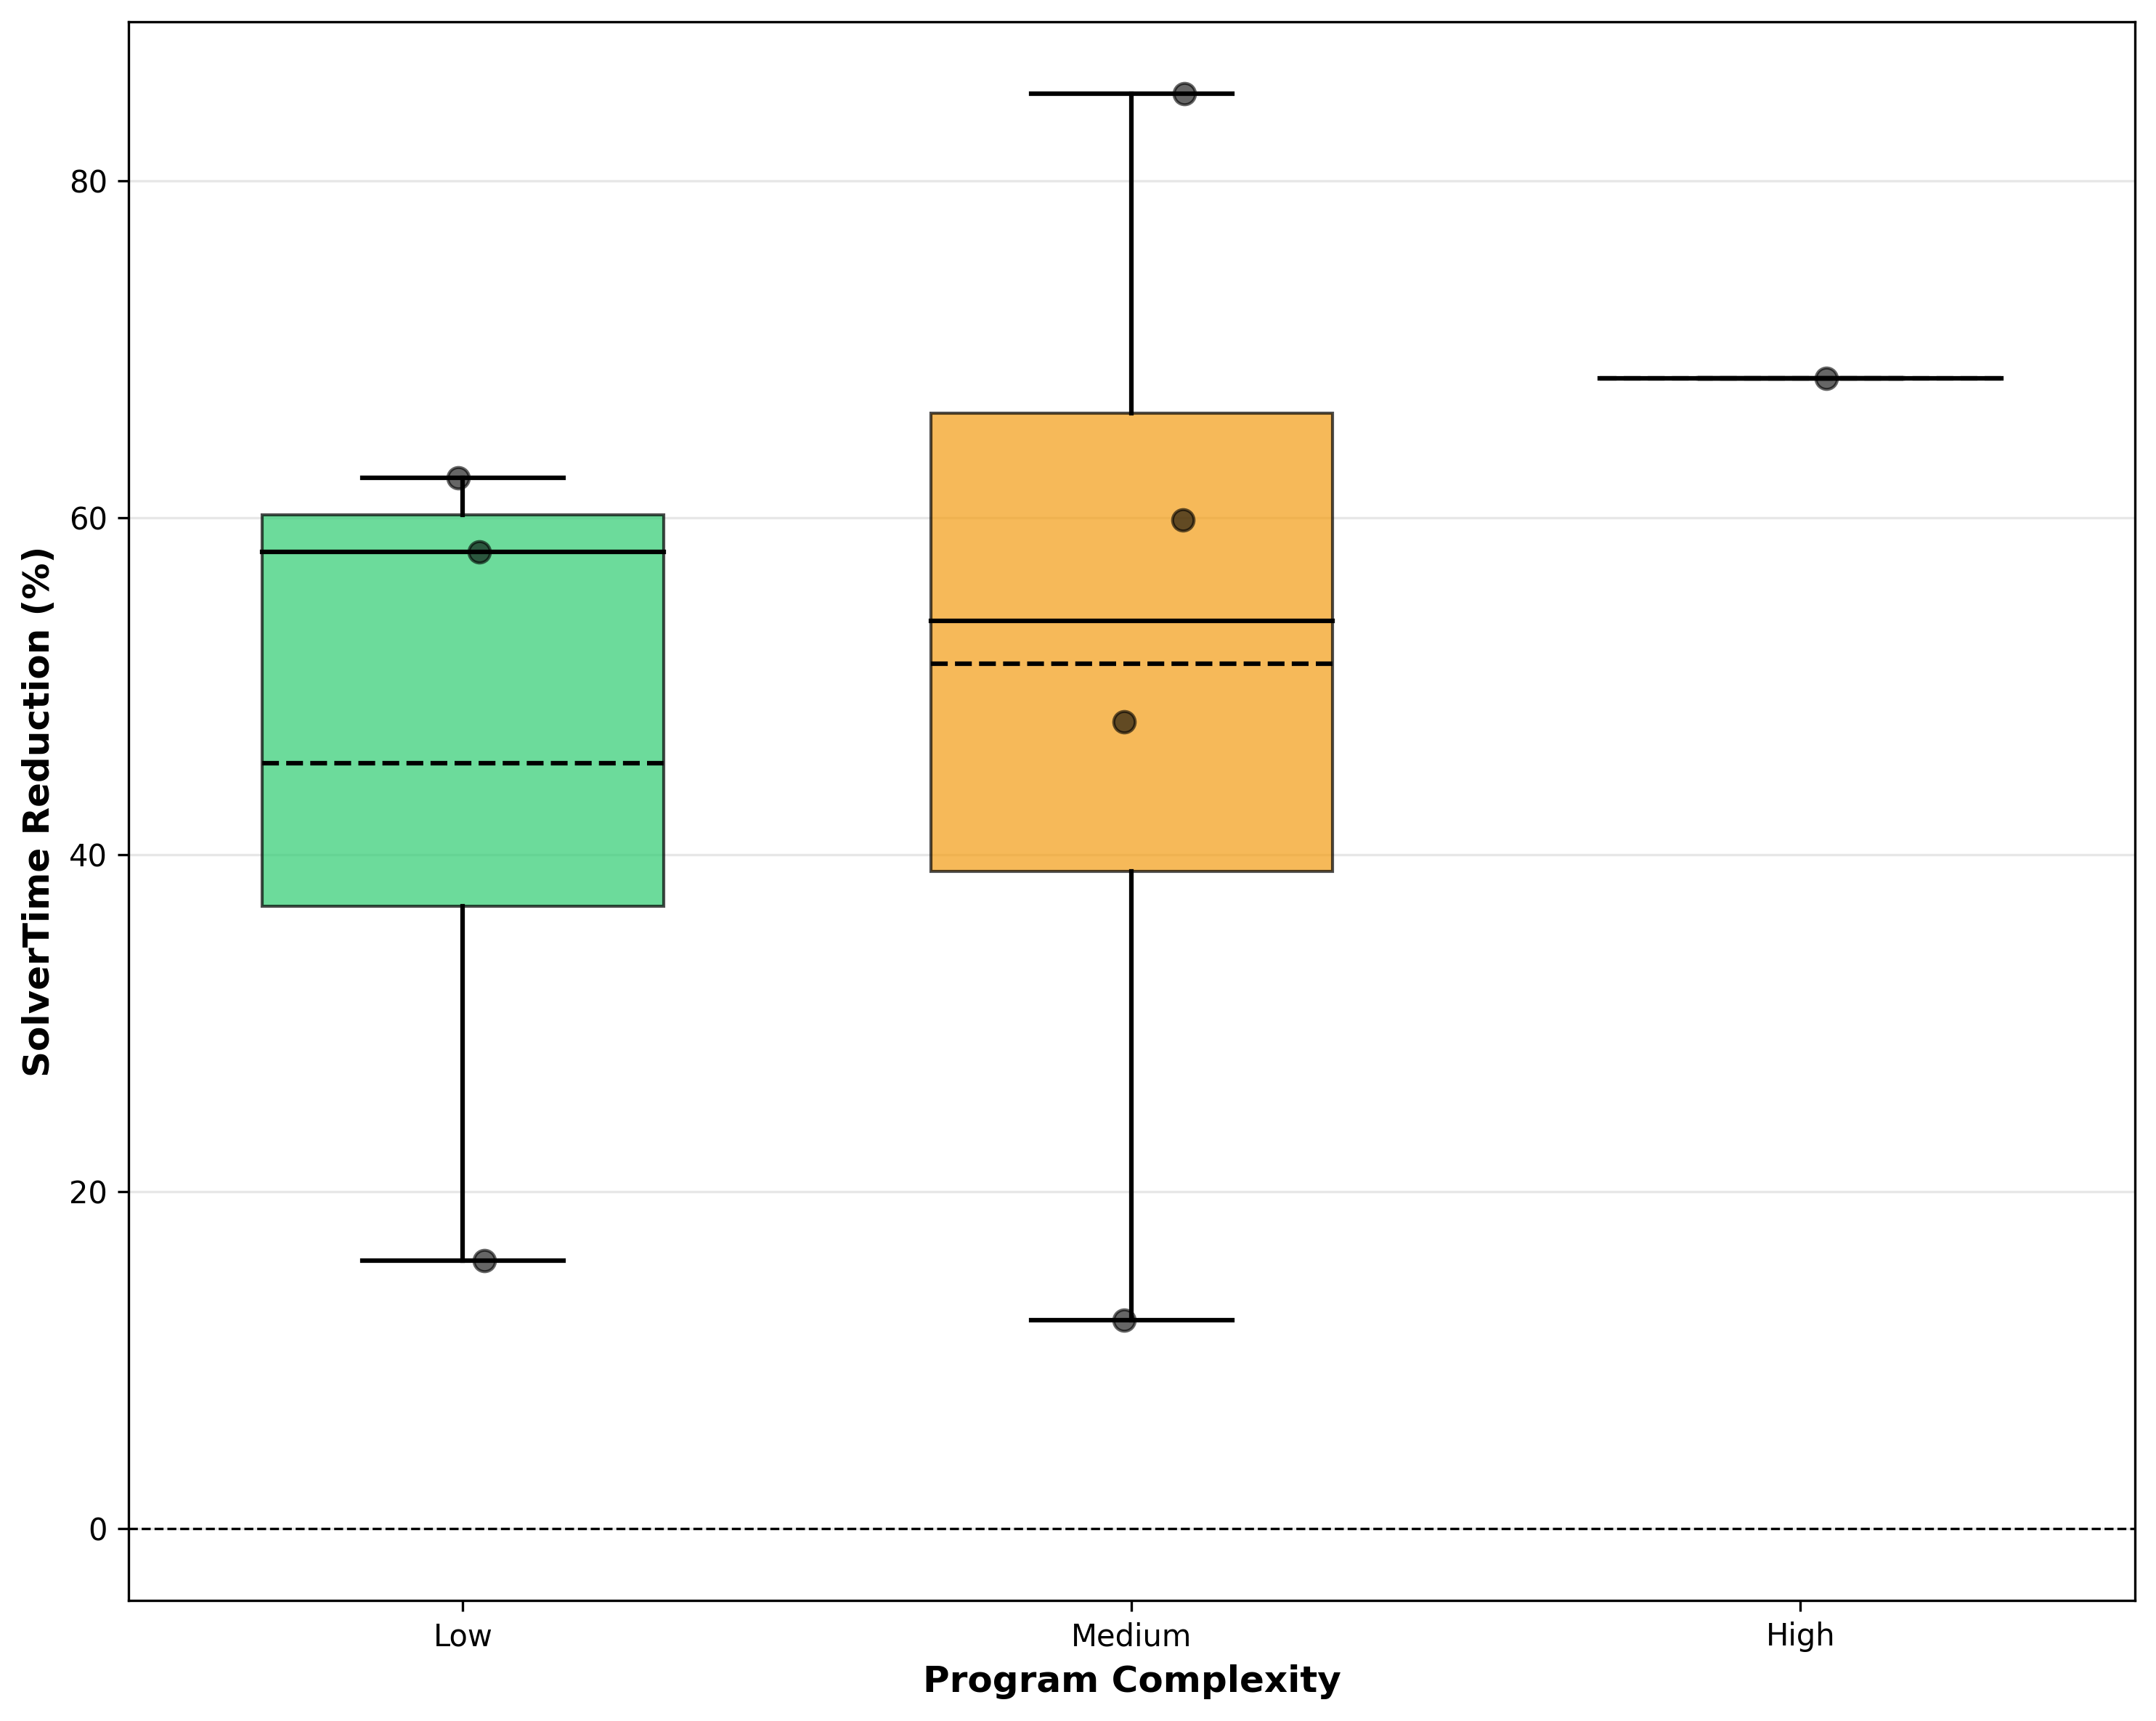

In [8]:
# Option 2: Box Plot - Show distribution by complexity
if not rq3_df.empty:
    fig, ax = plt.subplots(figsize=(10, 8))
    # Prepare data by complexity
    complexity_order = ['Low', 'Medium', 'High']
    data_by_complexity = [rq3_df[rq3_df['Complexity'] == comp]['SolverTime Reduction (%)'].values 
                          for comp in complexity_order if comp in rq3_df['Complexity'].values]
    labels = [comp for comp in complexity_order if comp in rq3_df['Complexity'].values]
    # Create box plot
    bp = ax.boxplot(data_by_complexity, labels=labels, patch_artist=True, 
                    widths=0.6, showmeans=True, meanline=True)
    # Color the boxes
    colors = {'Low': '#2ecc71', 'Medium': '#f39c12', 'High': '#e74c3c'}
    for patch, label in zip(bp['boxes'], labels):
        patch.set_facecolor(colors[label])
        patch.set_alpha(0.7)
    # Style the plot
    for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color='black', linewidth=1.5)
    ax.set_ylabel('SolverTime Reduction (%)', fontsize=12, fontweight='bold')
    ####ax.set_title('RQ3: SolverTime Reduction Distribution by Complexity', fontsize=14, fontweight='bold')
    ax.set_xlabel('Program Complexity', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
    # Add individual data points with jitter
    np.random.seed(42)  # For reproducibility
    for i, (comp, data) in enumerate(zip(labels, data_by_complexity)):
        x_pos = i + 1
        y_pos = data
        # Add some jitter for better visibility
        if len(data) > 0:
            x_jitter = np.random.normal(0, 0.05, len(data))
            ax.scatter(x_pos + x_jitter, y_pos, alpha=0.6, s=50, color='black', zorder=3)
    plt.tight_layout()
    plt.savefig('rq3-box-plot-complexity.pdf', dpi=300, bbox_inches='tight')
    plt.savefig('rq3-box-plot-complexity.png', dpi=300, bbox_inches='tight')
    print("Option 2 saved: rq3-box-plot-complexity.pdf and .png")
    plt.show()
else:
    print("Warning: No data available for box plot")


### Option 3: Regression Plot (Scalability with Program Size)


Option 3 saved: rq3-regression-scalability.pdf and .png


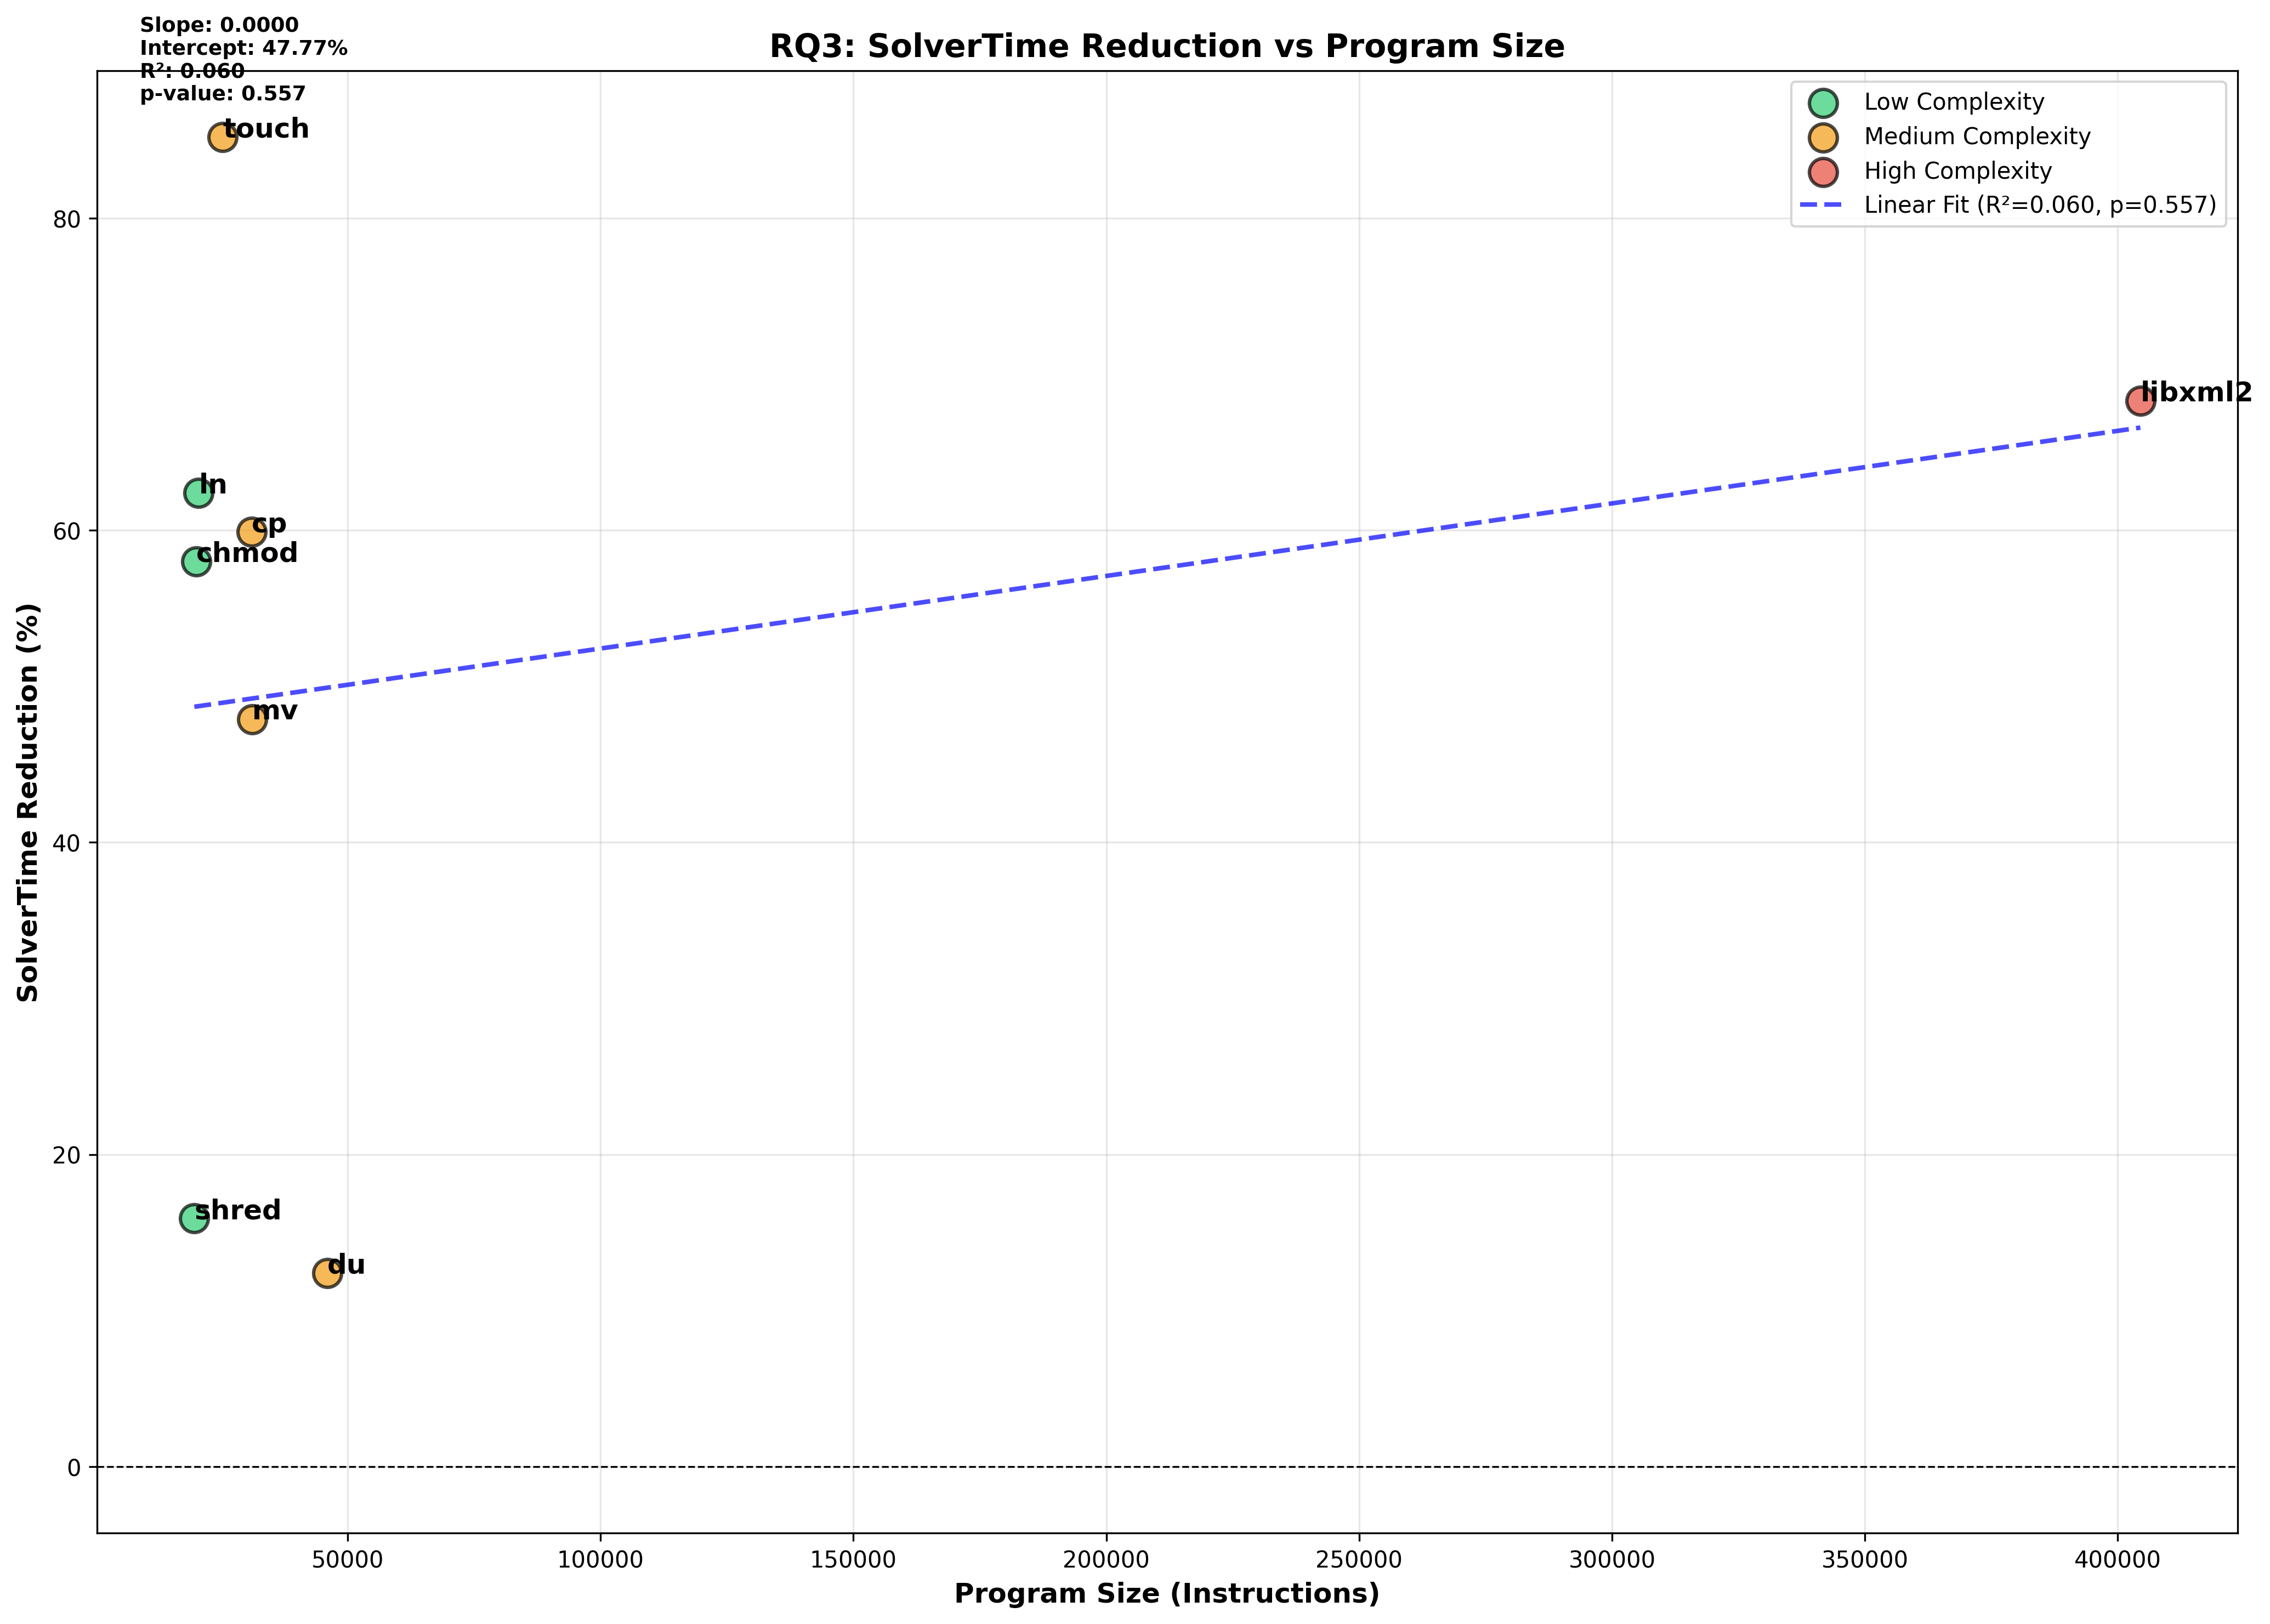

In [ ]:
# Option 3: Regression Plot - Show scalability with program size
if not rq3_df.empty:
    # Check if scipy is available, otherwise use numpy for basic regression
    try:
        from scipy import stats
        use_scipy = True
    except ImportError:
        print("Warning: scipy not available. Using numpy for basic regression.")
        use_scipy = False
    fig, ax = plt.subplots(figsize=(14, 10))
    # Color code by complexity
    complexity_colors = {'Low': '#2ecc71', 'Medium': '#f39c12', 'High': '#e74c3c'}
    for complexity in ['Low', 'Medium', 'High']:
        complexity_data = rq3_df[rq3_df['Complexity'] == complexity]
        if not complexity_data.empty:
            ax.scatter(complexity_data['Instructions'], 
                      complexity_data['SolverTime Reduction (%)'],
                      s=150, c=complexity_colors[complexity],
                      label=f'{complexity} Complexity',
                      alpha=0.7, edgecolors='black', linewidth=1.5, zorder=3)
    # Add program labels
    for _, row in rq3_df.iterrows():
        ax.annotate(row['Program'],
                   (row['Instructions'], row['SolverTime Reduction (%)']),
                   fontsize=12, fontweight='bold')
    # Fit regression line
    x = rq3_df['Instructions'].values
    y = rq3_df['SolverTime Reduction (%)'].values
    # Calculate linear regression
    if use_scipy:
        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
        r_squared = r_value ** 2
    else:
        # Basic linear regression using numpy
        coeffs = np.polyfit(x, y, 1)
        slope = coeffs[0]
        intercept = coeffs[1]
        # Calculate R² manually
        y_pred = slope * x + intercept
        ss_res = np.sum((y - y_pred) ** 2)
        ss_tot = np.sum((y - np.mean(y)) ** 2)
        r_squared = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
        p_value = 0.0  # Not available without scipy
        r_value = np.sqrt(r_squared) if r_squared >= 0 else 0
    line_x = np.linspace(x.min(), x.max(), 100)
    line_y = slope * line_x + intercept
    # Plot regression line
    if use_scipy:
        ax.plot(line_x, line_y, '--', color='blue', linewidth=2, alpha=0.7, 
                label=f'Linear Fit (R²={r_squared:.3f}, p={p_value:.3f})')
    else:
        ax.plot(line_x, line_y, '--', color='blue', linewidth=2, alpha=0.7, 
                label=f'Linear Fit (R²={r_squared:.3f})')
    # Add confidence interval (optional, using simple approximation)
    # You can add more sophisticated confidence intervals if needed
    ax.set_xlabel('Program Size (Instructions)', fontsize=12, fontweight='bold')
    ax.set_ylabel('SolverTime Reduction (%)', fontsize=12, fontweight='bold')
    ax.set_title('RQ3: SolverTime Reduction vs Program Size', fontsize=14, fontweight='bold')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
    # Add regression statistics text
    if use_scipy:
        stats_text = f'Slope: {slope:.4f}\nIntercept: {intercept:.2f}%\nR²: {r_squared:.3f}\np-value: {p_value:.3f}'
    else:
        stats_text = f'Slope: {slope:.4f}\nIntercept: {intercept:.2f}%\nR²: {r_squared:.3f}'
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=9, fontweight='bold')
    plt.tight_layout()
    plt.savefig('rq3-regression-scalability.pdf', dpi=300, bbox_inches='tight')
    plt.savefig('rq3-regression-scalability.png', dpi=300, bbox_inches='tight')
    print("Option 3 saved: rq3-regression-scalability.pdf and .png")
    plt.show()
else:
    print("Warning: No data available for regression plot")


## Summary

All figures have been generated and saved in the current directory:

- `rq1-parallel-coordinates-new.pdf` and `.png`
- `rq1-improvement-heatmap-new.pdf` and `.png`
- `rq2-overhead-benefit-new.pdf` and `.png`
- `rq3-performance-variation.pdf` and `.png`

**Total: 8 files (4 PDFs + 4 PNGs)**
